In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH  = '../resources/model_results/svm_rbf_grid.npy'
MODEL_PATH  = '../resources/best_models/svm_rbf.npy'
TRAIN_MODEL = False

# Support Vector Machine With RBF Kernel Model

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

The `SVC` classifier allows to use different kernels. RBK kernel add a new gamma hyperparameter to tune with grid search. The gamma parameter controls how much the points affect each other. Larger is the gamma value, closer the data points should be to produce significant kernel values. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components
* Penalty parameter C of the error term
* RBF kernel coefficient $\gamma$
 
Note that because the imbalance of our target variable, we apply weights inversely proportional to class frequencies: `class_weight='balanced'`.

In [4]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]
svc__C = np.logspace(-2, 4, 7)
svc__gamma = np.logspace(-2, 0, 10)


# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('svc', SVC(kernel='rbf', class_weight='balanced', random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'svc__C': svc__C,
        'svc__gamma': svc__gamma
    })
    
    # Scorers
    average_precision_scorer = make_scorer(average_precision_score, 
                                           greater_is_better=True, 
                                           needs_proba=False,
                                           needs_threshold=True)
    
    roc_auc_scorer = make_scorer(roc_auc_score, 
                                 greater_is_better=True, 
                                 needs_threshold=True)
    
    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': roc_auc_scorer,
            'average_precision': average_precision_scorer
        },
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [5]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('C', r['param_svc__C']),
    ('gamma', r['param_svc__gamma']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 350


,n_components,C,gamma,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,0.01,0.01,0.588954,0.587380,0.001574,0.004555,0.006381
1,9,0.01,0.016681,0.657440,0.657417,0.000023,0.004118,0.018357
2,9,0.01,0.0278256,0.690347,0.690619,0.000272,0.002923,0.013992
3,9,0.01,0.0464159,0.730148,0.728287,0.001862,0.004239,0.018986
4,9,0.01,0.0774264,0.763635,0.761704,0.001931,0.004850,0.019104


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

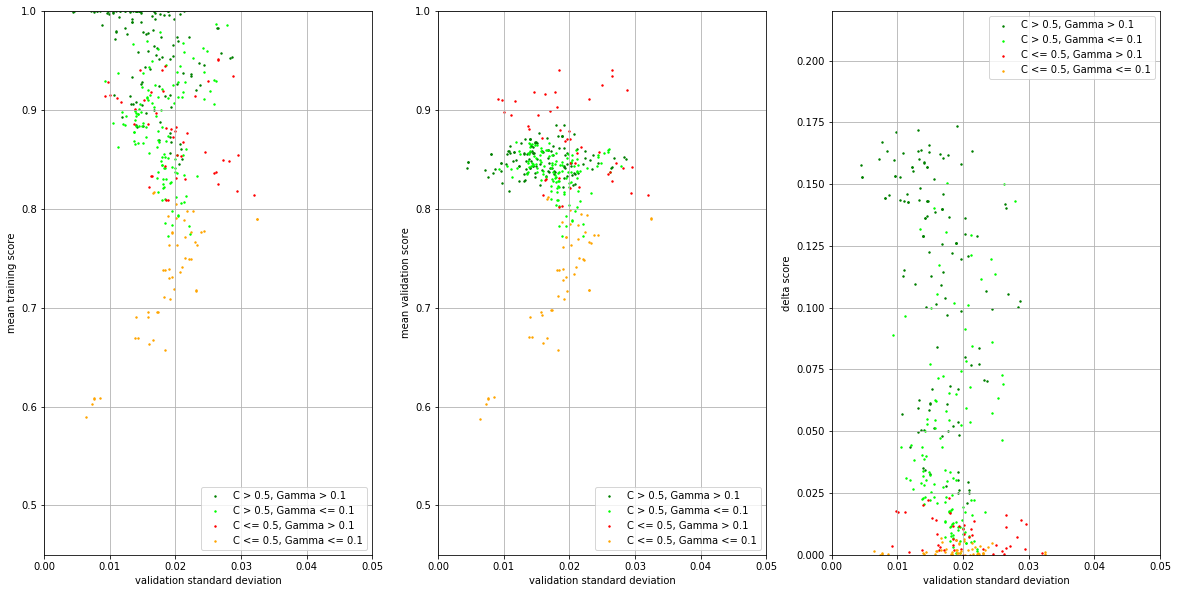

In [6]:
# Filters
c_filter = df.C > 0.5
gamma_filter = df.gamma > 0.1

# Plot vars
legend_loc = ['lower right', 'lower right', 'upper right']
ylabel = ['mean training score', 'mean validation score', 'delta score']
ylims = [(0.45, 1), (0.45, 1), (0, 0.22)]

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[c_filter & gamma_filter], df.loc[c_filter & gamma_filter, var], color='green', label='C > 0.5, Gamma > 0.1', s=2)
    ax[i].scatter(df.std_valid_score[c_filter & ~gamma_filter], df.loc[c_filter & ~gamma_filter, var], color='#00FF00', label='C > 0.5, Gamma <= 0.1', s=2)
    ax[i].scatter(df.std_valid_score[~c_filter & gamma_filter], df.loc[~c_filter & gamma_filter, var], color='red', label='C <= 0.5, Gamma > 0.1', s=2)
    ax[i].scatter(df.std_valid_score[~c_filter & ~gamma_filter], df.loc[~c_filter & ~gamma_filter, var], color='orange', label='C <= 0.5, Gamma <= 0.1', s=2)

    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, 0.05), ylim=ylims[i])
    ax[i].legend(loc=legend_loc[i])
    i += 1

plt.show()

Models with high C values quickly overfit the data, only small gamma value allow to prevent it. The best models, the red data points, have a C value below 0.5 and a gamma above 0.1.

Given the results, our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1%
* delta mean precision score <= 2.5%
* validation precision score >= 90%

In [7]:
# Model selection according to some wished criteria
f_std_valid = (df.std_valid_score <= 0.01)
f_delta_score = (df.delta_score <= 0.025)
f_valid_score = (df.mean_valid_score >= 0.9)

filter =  f_std_valid & f_delta_score & f_valid_score
best_models = df[filter].sort_values(by='delta_score', ascending=True)
best_models

,n_components,C,gamma,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
217,18,0.01,0.359381,0.914686,0.911269,0.003417,0.004277,0.009214
159,15,0.1,1,0.928126,0.910336,0.017790,0.002050,0.009771


The first model appears to be a good choice, it has the best validation standard deviation and mean validation precision score.

### Best model evaluation on the test set

We must now to train these model on the full training set and evaluate it on the test set :

In [8]:
# Best model hyperparameters
pca__n_components = best_models.n_components.values[0]
svc__C =  best_models.C.values[0]
svc__gamma = best_models.gamma.values[0]

if TRAIN_MODEL:
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca__n_components, random_state=0)),
        ('svc', SVC(C=svc__C, gamma=svc__gamma, kernel='rbf', class_weight='balanced', random_state=0))
    ])
    pipe.fit(X_train, y_train)
    
    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)
else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)

In [9]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('SVM with RBF Kernel Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('SVM with RBF Kernel Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
SVM with RBF Kernel Precision (training set):  0.906
SVM with RBF Kernel Precision (test set) :  0.909


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	510 (TN)	201 (FN)
Predicted P	 17 (FP)	170 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.909
Recall    :  0.458
Accuracy  :  0.757
F1 Score  :  0.609


The training and test precision scores are the same, at 91%, indicating that our model don't overfit the data.
This SVM with RBF kernel model is our best model in regards of the precision metric and it was quiet expected.

However, it's interesting to note that its recall is very bad compared to the other models, meaning that it miss a huge proportion of the exoplanets. It is a more opiniated precision focused model. Comparison with our second best precision model, the random forest model, it improves the precision by 2% at the cost of recall 38% lower...